# Product Classification 01

In this notebook we will :
* Utilize the learnings from the EDA
* Utlize the preprocessing we performed while performing EDA
* Use Product Title and Category code based features to learn/train a model
* Test against a test set and also evaluate our model

### Approach
A. **ETL** :
    1. Load the training dataset
    2. Preprocess this dataset to get required 3 columns with correct data types
B. **Feature Generation/Selection**:
    1. product_title is a free form text field
    2. Utilize this column to generate features using TFIDF (sklearn's tfidfvectorizer)
    3. A lot of numeric data related to serial and model numbers exists in the text.
    4. Use a custom preprocessor to replace all numeric data by common sentinels/symbols
C. **Modeling**
    1. The unique number of brand_ids is huge (approx 35k).
    2. Utilize category_id to reduce the scope, i.e. brand classification on per category basis
    3. This results in 1 model per category, i.e. a total of 609 models
    4. Perform 2 fold stratified cross validation using Logistic Regression, Multinomial Naive Bayesian and Decision Trees.
    5. Present results in a visual mannner (histogram of %age accuracy on a per model basis)
    
D. **Prediction**
    1. Use persisted models to predict brand_ids and report the same.
    
_Caveat : There are certain brands which have only single occurance in training set. These brands cannot be used in stratified sampling due to obvious reasons._

In [1]:
# Imports

# Pandas and Numpy for data structures and util functions
import re
import numpy as np
import pandas as pd

# Matplot for functions
import matplotlib.pyplot as plt

from IPython.display import display, HTML

%matplotlib inline
plt.rcParams['figure.figsize'] = (10,5)
pd.options.display.max_colwidth = 600

In [143]:
# util function to load and preprocess training data:
def train_etl(relative_filepath):
    raw_data = list()
    for line in open(relative_filepath):
        raw_data.append(re.split(r'(.*)\t(\d+)\t(\d+)$',line.split("\n")[0]))
    print "Rows read from file::",len(raw_data)
        
    raw_df = pd.DataFrame(raw_data, columns=['dummy_col1'
                                            ,'product_title'
                                            , 'brand_id'
                                            ,'category_id'
                                            ,'dummy_col2'                                
                                        ])
    print "Discarded rows::"
    display( raw_df[raw_df.dummy_col1!=''][['dummy_col1','dummy_col2']])
    raw_df = raw_df[(raw_df.dummy_col1 == '')&(raw_df.dummy_col2 == '')]

    # drop dummy columns from new dataframe
    raw_df.drop(['dummy_col1','dummy_col2'],axis=1,inplace=True)

    # convert to proper datatypes
    raw_df.loc[:,'category_id'] = raw_df.category_id.astype(np.int64)
    raw_df.loc[:,'brand_id'] = raw_df.brand_id.astype(np.int64)
    raw_df.loc[:,'product_title'] = raw_df.product_title.astype(str)
    return raw_df


# util function to load and preprocess test data:
def test_etl(relative_filepath):
    raw_data = list()
    for line in open(relative_filepath):
        raw_data.append(re.split(r'(.*)\t(\d+)$',line.split("\n")[0]))
    print "Rows read from file::",len(raw_data)
        
    raw_df = pd.DataFrame(raw_data, columns=['dummy_col1'
                                            ,'product_title'
                                            ,'category_id'
                                            ,'dummy_col2'                                
                                        ])
    print "Discarded rows::"
    display( raw_df[raw_df.dummy_col1!=''][['dummy_col1','dummy_col2']])
    raw_df = raw_df[(raw_df.dummy_col1 == '')&(raw_df.dummy_col2 == '')]

    # drop dummy columns from new dataframe
    raw_df.drop(['dummy_col1','dummy_col2'],axis=1,inplace=True)

    # convert to proper datatypes
    raw_df.loc[:,'category_id'] = raw_df.category_id.astype(np.int64)
    raw_df.loc[:,'product_title'] = raw_df.product_title.astype(str)
    return raw_df

In [3]:
# load and preprocess training data
train_df = train_etl(r'../data/classification_train.tsv')

Rows read from file:: 1000000
Discarded rows::


dummy_col1  \
218278                                                                                                                                                                                                                                                                                                                                                                                                                                                                 title\tbid\tcid   
246806                                                                                                                                                                                                                                                                                               " 2 Pack Panasonic Compatible KX-FA83 KXFA83 Laser Toner Cartridge, 2,500 Pa\tUnknown\tcomputers & accessories > cables & accessories > printer ink & toner > laser printer toner   
458263                                                                                                                                                                                                                                                                                                                                 "Brocade VDX 6720 - switch - 16 ports - rack-mountable\tBrocade Communication Systems\tcomputers & accessories > networking products > switches   
575503  "This hub is built strong and ideal for industrial environments. With the StarTech.com ST4200USBM 4-port hub you can wall-mount or install onto a DIN rail for convenient access to the ports. This four port industrial hub can be bus powered or self powered with a three wire terminal block connector 7-24V . Plug in your most demanding next-generation peripherals and still enjoy data transfer speed\tStarTech\tcomputers & accessories > networking products > hubs   

       dummy_col2  
218278       None  
246806       None  
458263       None  
575503       None

## Play time with text data
 * Analyse product title text
 * See if any further processing is required
 * Apply additional filtering

In [4]:
# Scikit Enter's the Ring
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english')
title_tfidf_matrix = tfidf_vectorizer.fit_transform(train_df.product_title.ix[0:10000])
feature_names = tfidf_vectorizer.get_feature_names() 

In [6]:
print len(feature_names)
print feature_names[0:50]
print feature_names[6250:]

6303
[u'00', u'000', u'001', u'002', u'003', u'004', u'005', u'006', u'007', u'008', u'008g', u'009', u'01', u'010', u'011', u'016', u'016g', u'018', u'01g', u'02', u'020', u'023', u'025', u'02g', u'03', u'03f', u'04', u'041', u'05', u'05a', u'06', u'07', u'08', u'09', u'090', u'0950', u'0gb', u'0ghz', u'0l', u'0m', u'0tb', u'0v', u'10', u'100', u'1000', u'10000', u'10000rpm', u'1000base', u'1000bsx', u'1000dpi']
[u'z2760', u'z33', u'z370', u'z40', u'z560', u'z565', u'z570', u'z580', u'z585', u'z710', u'z77', u'z77itx', u'z800', u'z820', u'z830', u'z87', u'z930', u'z935', u'zag', u'zagg', u'zalman', u'zbox', u'zcl', u'zcljiahe', u'ze01', u'zebra', u'zectron', u'zeimax', u'zelda', u'zen', u'zenbook', u'zenfone', u'zero', u'zig', u'zing', u'ziotek', u'zip', u'zipped', u'zipper', u'zippered', u'zippers', u'zizo', u'zl', u'zlxusa', u'zm', u'zone', u'zoom', u'zotac', u'zt', u'zte', u'zx', u'zyxel', u'\xb5g']


### Numbers in text
* Many numbers are coming up in features list
* They seem to be model numbers, specifications, sizes, etc
* We can try to replace them by a common sentinel like ```__custom_number__``` and ```__custom_spec__```

In [7]:
# preprocessor
def custom_number_preprocessor(text):
    text = text.lower()

    # Identify and replace spec related numbers with common sentinel
    text = re.sub(r'\b[0-9]+\b', '__custom_spec__', text) 
    
    # Identify and replace serial/model numbers with common sentinel
    text = re.sub(r'\b\w*\d+\w*\d?\b', '__custom_sno__', text)
    
    return text

In [8]:
# instantiate a vectorizer
custom_tfidf_vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english',preprocessor=custom_number_preprocessor)

# fit the corpus
title_tfidf_matrix = custom_tfidf_vectorizer.fit_transform(train_df.product_title)

# extract features
feature_names = custom_tfidf_vectorizer.get_feature_names() 

In [9]:
print "Number of features::",len(feature_names),"\n"
print "Random set of features::\n", feature_names[100:150],"\n"

Number of features:: 47449 

Random set of features::
[u'ablegrid', u'ablenet', u'ablet', u'ableto', u'ableton', u'ableware', u'ably', u'abm', u'abmd', u'aboard', u'abocom', u'aboim', u'abolina', u'abolisher', u'abortion', u'abraham', u'abrasion', u'abrasive', u'abs', u'absalom', u'absinthe', u'absol', u'absolute', u'absolutely', u'absolutepower', u'absolution', u'absorb', u'absorbant', u'absorbent', u'absorber', u'absorbers', u'absorbing', u'absorbs', u'absorption', u'absplus', u'abstarct', u'abstergo', u'abstract', u'abstracted', u'abstraction', u'abstractism', u'abstracts', u'abstrakciya', u'absurd', u'abt', u'abu', u'abundant', u'abus', u'abuse', u'abyss'] 



** The number of features has gone down considerably**

### Save Feature Matrix

In [ ]:
from scipy.io import mmwrite, mmread

print "Shape of title matrix::",title_tfidf_matrix.shape
mmwrite(r'../data/train_product_title_feature_matrix.mtx', title_tfidf_matrix)

### Sampling
* Data needs to be split on a per category basis for model building and evaluation
* Since we need representation of each brand_id, stratified sampling should help
* Some brands have only one instance in training sample. We handle those categories separately(no cross validation)

### Brands with <= 2 samples

In [10]:
train_brand_lowsamplecount = train_df.groupby("brand_id").filter(lambda x: len(x) == 1)
train_brand_highsamplecount = train_df.groupby("brand_id").filter(lambda x: len(x) > 1)
print "count of low_count brands::",len(train_brand_lowsamplecount.brand_id.unique())
print "count of high_count brands::",len(train_brand_highsamplecount.brand_id.unique())
display(train_brand_lowsamplecount.head()) 

count of low_count brands:: 17570
count of high_count brands:: 18132


product_title  \
23                                                                                   HP Pavilion dv6-1102tx Laptop Screen 15.6 LCD CCFL WXGA HD   
204                                                                                                                 ioSafe Rugged Portable Alum   
309                                                                     iPadApple iPad Connection Kit USB Camera Connector + SD Card Reader Kit   
320                                                                                                 Emerge Tech 3\' USB 2.0 Universal Cable Kit   
475  Tandberg 3536-LTO LTO-6 HH - Tape drive - LTO Ultrium 2.5 TB / 6.25 TB - Ultrium 6 - 8Gb Fibre Channel - internal - 5.25 inch - encryption   

     brand_id  category_id  
23       6911          415  
204     14455          510  
309     30539          569  
320     11938          390  
475       134          353

In [11]:
train_brand_highsamplecount.reset_index(inplace=True)
train_brand_highsamplecount.drop('index',axis=1,inplace=True)
display(train_brand_highsamplecount.head())

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


product_title  \
0  120GB Hard Disk Drive with 3 Years Warranty for Lenovo Essential B570 Laptop Notebook HDD Computer - Certified 3 Years Warranty from Seifelden   
1                   "TOSHIBA SATELLITE L305-S5919 LAPTOP LCD SCREEN 15.4"" WXGA CCFL SINGLE SUBSTITUTE REPLACEMENT LCD SCREEN ONLY. NOT A LAPTOP"   
2                                                       Hobby-Ace Pixhawk PX4 RGB External LED Indicator USB Module for Pixhawk Flight Controller   
3                                                                                                                               Pelicans mousepad   
4                                                                                                 P4648-60029 Hewlett-Packard Tc2100 System Board   

   brand_id  category_id  
0      3950            8  
1     35099          324  
2     21822          510  
3     44629          260  
4     42835           68

In [12]:
train_brand_highsamplecount.groupby("brand_id").filter(lambda x: len(x) > 1)

product_title  \
0                                                                                                                                                                                               120GB Hard Disk Drive with 3 Years Warranty for Lenovo Essential B570 Laptop Notebook HDD Computer - Certified 3 Years Warranty from Seifelden   
1                                                                                                                                                                                                                "TOSHIBA SATELLITE L305-S5919 LAPTOP LCD SCREEN 15.4"" WXGA CCFL SINGLE SUBSTITUTE REPLACEMENT LCD SCREEN ONLY. NOT A LAPTOP"   
2                                                                                                                                                                                                                                                    Hobby-Ace Pixhawk PX4 RGB External LED Indicator USB Module for Pixhawk Flight Controller   
3                                                                                                                                                                                                                                                                                                                            Pelicans mousepad   
4                                                                                                                                                                                                                                                                                              P4648-60029 Hewlett-Packard Tc2100 System Board   
5                                                                                                                                                                                                                                                                                                       Ectaco EI900 SD Card English - Italian   
6                                                                                                                                                                                                                                                                       Zippered Pocket Black School Laptop Tablet Dual Straps Deluxe Backpack   
7                                                                                                                                                                                                                                                                                                     GP Mtr, 3 Ph, ODP, 3 HP, 1800 rpm, 182TC   
8                                                                                                                                                                                                                                                                                      DIGI CM 16 PORT RJ-45 CONSOLE SERVER - Model#: 70001910   
9                                                                                                                                                                                                                                                                    Lenovo Ibm Thinkpad R52-1859 Laptop AC adapter, power adapter Replacement   
10                                                                                                                                                                                                                                      MSI FM2-A85XMA-E35 - FM2 Trinity AMD A85X Chipset DDR3 PCI Express HDMI/D-SUB/DVI microATX Motherboard   
11                                                                                                                                                                                                                                                              Zerlar Ca

### Utility functions

In [13]:
# imports
from sklearn.cross_validation import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from datetime import datetime

In [14]:
# utility function to perform 2fold stratified cross validation based on specified classifier
def cv_models(df,classifier,verbose=True):
    scores = list()
    try:
        # instantiate vectorizer
        custom_tfidf_vectorizer = TfidfVectorizer(stop_words='english',preprocessor=custom_number_preprocessor)

        # instantiate a pipeline
        pipeline = Pipeline([
        ('tfidf', custom_tfidf_vectorizer),
        ('clf', classifier),
        ])
        
        # instantiate stratified k fold object
        skf = StratifiedKFold(df.brand_id.values,n_folds=2)
        
        # perform cross validation
        for train_index, test_index in skf:
            # split data into train and test
            X_train, X_test = df.product_title.iloc[train_index], df.product_title.iloc[test_index]
            y_train, y_test = df.brand_id.iloc[train_index], df.brand_id.iloc[test_index]
            
            # fit the model/pipeline
            pipeline.fit(X_train, y_train.values)
            
            # calculate accuracy score
            score = pipeline.score(X_test,y_test.values)
            if verbose: 
                print "Score::",score
            
            # accumulate score 
            scores.append(score)
    except Exception:
        # certain products have only 1 sample
        if verbose:
            print "Oops! Something went wrong"
        scores.append(0)
    finally:
        # return the best score
        return max(scores) if len(scores)>0 else -1

### Cross Validating on a few categories for scores

In [16]:
# cross validate
unique_cats = train_brand_highsamplecount.groupby("brand_id").filter(lambda x: len(x) >1).category_id.unique().tolist()

In [90]:
# Perform scoring for top 5 categories 
for cat in unique_cats[0:5]:
    print "Category::",cat
    print "LR scores::"
    cv_models(train_brand_highsamplecount[train_brand_highsamplecount.category_id==cat],
              classifier = LogisticRegression())
    print 
    
    print "DT scores::"
    cv_models(train_brand_highsamplecount[train_brand_highsamplecount.category_id==cat],
              classifier = DecisionTreeClassifier())
    print
    
    print "MNB scores::"
    cv_models(train_brand_highsamplecount[train_brand_highsamplecount.category_id==cat],
              classifier = MultinomialNB())
    print '*'*10

Category:: 8
LR scores::
Score:: 0.762325239146
Score:: 0.837489943685

DT scores::
Score:: 0.79838116262
Score:: 0.855993563958

MNB scores::
Score:: 0.617365710081
Score:: 0.653258246179
**********
Category:: 324
LR scores::
Score:: 0.843781428093
Score:: 0.865748709122

DT scores::
Score:: 0.864230640295
Score:: 0.871944922547

MNB scores::
Score:: 0.713375796178
Score:: 0.735283993115
**********
Category:: 510
LR scores::
Score:: 0.621065088757
Score:: 0.704134017833

DT scores::
Score:: 0.69325443787
Score:: 0.770062145366

MNB scores::
Score:: 0.431479289941
Score:: 0.473115374223
**********
Category:: 260
LR scores::
Score:: 0.769606864897
Score:: 0.789561657854

DT scores::
Score:: 0.827712366128
Score:: 0.844823469214

MNB scores::
Score:: 0.569081354354
Score:: 0.579771448064
**********
Category:: 68
LR scores::
Score:: 0.690097402597
Score:: 0.766142159523

DT scores::
Score:: 0.726136363636
Score:: 0.800144691626

MNB scores::
Score:: 0.540909090909
Score:: 0.5972146862
***

### Average scores per Stratified Cross Validation

In [17]:
max_scores = list()
counter = 1
for cat in unique_cats:
    counter = counter + 1
    if counter%10 == 0:
        print "Categories done::",counter
    max_scores.append(cv_models(train_brand_highsamplecount[train_brand_highsamplecount.category_id==cat],
                                classifier = LogisticRegression(),verbose=False))

C:\Anaconda2\lib\site-packages\sklearn\cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=2.
  % (min_labels, self.n_folds)), Warning)


Categories done:: 10
Categories done:: 20
Categories done:: 30
Categories done:: 40
Categories done:: 50
Categories done:: 60
Categories done:: 70
Categories done:: 80
Categories done:: 90
Categories done:: 100
Categories done:: 110
Categories done:: 120
Categories done:: 130
Categories done:: 140
Categories done:: 150
Categories done:: 160
Categories done:: 170
Categories done:: 180
Categories done:: 190
Categories done:: 200
Categories done:: 210
Categories done:: 220
Categories done:: 230
Categories done:: 240
Categories done:: 250
Categories done:: 260
Categories done:: 270
Categories done:: 280
Categories done:: 290
Categories done:: 300
Categories done:: 310
Categories done:: 320
Categories done:: 330
Categories done:: 340
Categories done:: 350
Categories done:: 360
Categories done:: 370
Categories done:: 380
Categories done:: 390
Categories done:: 400
Categories done:: 410
Categories done:: 420
Categories done:: 430
Categories done:: 440
Categories done:: 450
Categories done:: 4

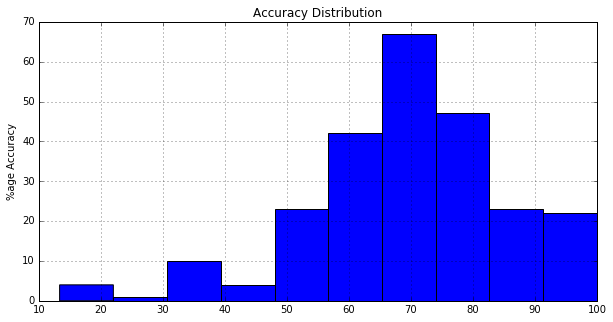

In [173]:
np_max_scores = np.array(max_scores)
scores_df = pd.DataFrame({'scores':np_max_scores*100,'cats':unique_cats})
hist_gram = scores_df[scores_df.scores>0].scores.hist()
hist_gram.set_title("Accuracy Distribution")
hist_gram.set_ylabel("%age Accuracy")

In [44]:
print "Average Accuracy score::",np.average(np_max_scores[np_max_scores>0.0])*100,"%"

Average Accuracy score:: 69.4785621149 %


** Scores are quite encouranging for Logistic Regression**

In [72]:
# Build model on a per category basis
def learn_cf(df):
    if df.brand_id.nunique() < 2:
        classifier = DecisionTreeClassifier()
        suffix="_dt_model"
    else:
        classifier = LogisticRegression()
        suffix="_lr_model"
    
    
    custom_tfidf_vectorizer = TfidfVectorizer(stop_words='english',preprocessor=custom_number_preprocessor)
    
    pipeline = Pipeline([
    ('tfidf', custom_tfidf_vectorizer),
    ('clf', classifier),
    ])
    
    pipeline.fit(df.product_title,df.brand_id)
    
    joblib.dump(pipeline,r'../models/category_'+str(df.category_id.iloc[0])+suffix)
    return True

### Save the models for testing

In [73]:
print "unique cats::",train_df.category_id.nunique()

unique cats:: 609


In [59]:
print "Cross Validation starts::",str(datetime.now())
cat_models = train_df.groupby('category_id').apply(learn_cf)
print "Cross Validation Ends::",str(datetime.now())

Cross Validation starts:: 2016-10-19 20:52:36.395000
Cross Validation Ends:: 2016-10-19 20:52:36.418000
Cross Validation starts:: 2016-10-19 20:52:36.418000
Cross Validation Ends:: 2016-10-19 20:52:36.519000
Cross Validation starts:: 2016-10-19 20:52:36.520000
Cross Validation Ends:: 2016-10-19 20:52:36.574000
Cross Validation starts:: 2016-10-19 20:52:36.574000
Cross Validation Ends:: 2016-10-19 20:52:36.634000
Cross Validation starts:: 2016-10-19 20:52:36.635000
Cross Validation Ends:: 2016-10-19 20:54:04.514000
Cross Validation starts:: 2016-10-19 20:54:04.528000
Cross Validation Ends:: 2016-10-19 20:54:04.560000
Cross Validation starts:: 2016-10-19 20:54:04.560000
Cross Validation Ends:: 2016-10-19 20:54:04.601000
Cross Validation starts:: 2016-10-19 20:54:04.602000
Cross Validation Ends:: 2016-10-19 20:54:27.427000
Cross Validation starts:: 2016-10-19 20:54:27.428000
Cross Validation Ends:: 2016-10-19 20:54:27.479000
Cross Validation starts:: 2016-10-19 20:54:27.479000
Cross Valid

### Testing Times
* Load test dataset
* Attempt classification with saved models/pipeline

In [75]:
test_df = test_etl(r'../data/classification_blind_set_corrected.tsv')

Rows read from file:: 619240
Discarded rows::


Empty DataFrame
Columns: [dummy_col1, dummy_col2]
Index: []

In [77]:
display(test_df.head())

product_title  \
0                                                                                                    HDE Slim Lightweight Auto Sleep Wake Smart Cover Case Stand for iPad Air 5ht Gen Sky Blue    
1               "V7 Black Toner Cartridge For Canon Image Class D1120, D1150, D1170, D1180 120 2617B001aa 5K Yld - Laser - 5000 Page ""Product Category: Print Supplies/Ink/Toner Cartridges"""   
2  "Decalrus - Matte Protective Decal Skin skins Sticker for Samsung Galaxy Tab 3 with 10.1"" screen IMPORTANT: Must view ""IDENTIFY"" image for correct model case cover MATGalaxyTAB3_10-304"   
3                                                              Vantec Thermal Technologies 89661 Vantec Accessory Nst-d300s3 2.5inch/3.5inch Sata I/ii To Usb3.0 Nexstar Hard Drive Dock Retail   
4                                 Fintie Samsung Galaxy Tab Pro 10.1 Folio Case - Slim Fit Leather Cover for TabPro 10.1-inch Tablet SM-T520/T525 with Auto Sleep/Wake Feature, Giraffe Magenta   

   category_id  
0          367  
1          625  
2          250  
3          309  
4           71

### Top Categories in Test Data
Distribution is quite similar

In [78]:
top_n = 20
top_cats = test_df.category_id.value_counts().sort_values(ascending=False).head(top_n).index.tolist()
print top_cats

train_top_cats = train_df.category_id.value_counts().sort_values(ascending=False).head(top_n).index.tolist()
print train_top_cats

[260, 625, 483, 666, 618, 367, 603, 71, 390, 539, 342, 313, 415, 520, 366, 59, 358, 442, 647, 287]
[260, 625, 483, 666, 618, 367, 603, 71, 390, 342, 539, 415, 313, 366, 520, 59, 442, 358, 647, 287]


In [96]:
# Predict using persisted models
def predict_brand(df):
    pipeline = None
    try:
        try:
            suffix="_dt_model"
            pipeline = joblib.load(r'../models/category_'+str(df.category_id.iloc[0])+suffix)    
        except Exception as e:
            suffix="_lr_model"
            pipeline = joblib.load(r'../models/category_'+str(df.category_id.iloc[0])+suffix)
    except Exception as e:
        pipeline = None
    finally:
        if pipeline:
            df.loc[:,'_brand_id'] = pipeline.predict(df.product_title)
        else:
            # Assign a sentinel for products which do not have a category in training set
            df.loc[:,'_brand_id'] = -99
    return df

In [80]:
pred = test_df[test_df.category_id.isin(top_cats[0:1])].groupby('category_id').apply(predict_brand)

In [81]:
pred.head()

product_title  \
25                       Tweety Bird Cartoon Personalized Custom Gaming Mousepad Rectangle Mouse Mat / Pad Office Accessory And Gift Design-LL688   
43                            26x21cm / 10x8inch Mouse Pad accurate cloth nature rubber Smooth Excellent for All Mouse Types Dodge car logo super   
49                                                                                                                            Guess Who mouse pad   
54                                                                                                                         Golden Eagle mouse pad   
63  URDesigner Mousepad Grass And Sky Mouse Pad Desktop Mousepad Laptop Mousepads Comfortable Table Desk Computer Mouse Mat Cute Gaming Mouse Pad   

    category_id  _brand_id  
25          260      12898  
43          260      41873  
49          260      20607  
54          260      44629  
63          260      40313

### Predict for all categories

In [97]:
print "Predcitions Start Time::",str(datetime.now())
pred = test_df.groupby('category_id').apply(predict_brand)
print "Predcitions End Time::",str(datetime.now())

Predcitions Start Time:: 2016-10-20 09:36:02.089000
Predcitions End Time:: 2016-10-20 09:37:34.496000


In [116]:
print "Products not predicted::",pred[pred._brand_id==-99].shape

Products not predicted:: (118, 3)


In [112]:
print "Are all categories of training available in test::",set(
                train_df.category_id.unique().tolist()).issuperset(
                    set(pred[pred._brand_id==-99].category_id.unique().tolist()))
print "Sample categories in test set::",pred[pred._brand_id==-99].category_id.unique()[0:10]

print "Categories not found in train but are in test::",pred[pred._brand_id==-99].category_id.nunique()

Are all categories of training available in test:: False
Sample categories in test set:: [674  96 151 345 417  64 446 200 349 412]
Categories not found in train but are in test:: 96


In [118]:
unpredicted_test = pred[pred._brand_id==-99]
display(unpredicted_test)

product_title  \
8757    "USG New Release! * H.265 Compression * 5MP 3744x1408 @ 30FPS * IP Bullet Security Camera: 2.8-12mm 5MP Lens, Power Over Ethernet, 72x IR LEDs For 200ft Night Vision, 1/1.8"" Sony IMX178 Sensor + Hi3516A DSP, Weatherproof, ONVIF 2.4, Remote Viewing On Phones + Computers *** Ideal For Business & Industrial Applications"   
11412                                                                                                                                                                                                                                                                                                          "70"" LCD Public Display"   
22256                                                                                                                                                                                                                                                                                      GJY WS-980 Model Car Loudspeaker Box , Silver   
22475                                                                                                                                                                                                                                            "Adjustable Rotating Footrest, Extra-Wide, 17 3/4 x 14 x 4"", Black by KELLY COMPUTERS"   
23543                                                                                                                                                                                                                        MCH-ATH-EQ500 3.5MM Mini In-Ear Earphone for T-388 Walkie Talkie with Microphone for Handheld Two Way Radio   
38693                                                                                                                                                                                                                                                                       3dRose dpp_13301_1 Wall Clock, Computers Room, 10 by 10-Inch   
39573                                                                                                                                                                                                                                                                          JJE LAN Leather Bobbin Winder for Cables/Earphone , Brown   
48532                                                                                                                                                                                                                         ZCLATH-EQ500 3.5MM Mini In-Ear Earphone for T-388 Walkie Talkie with Microphone for Handheld Two Way Radio   
51672                                                                                                                                                                                                                                                                        Display Calibration Sensor Colorimeter for Md & Spectraview   
59215                                                                                                                                                                                                                                                                                         YAN CP-3508 USB3.0 Front Panel 100% Copper   
61688                                                                                                                                                                                   27000mAh Universal External Battery for Camcorder, DVD Players, Digital Album, Digital Camera, Ebook, Game System and Laptop Computers Dark Grey   
64366                                                                                                                                                                                                                                                                                         SOL Aluminum Memory Heat Spreader , Silver   

### Handling Unpredicted Products
* Since there are certain categories only present in test, we need to build a separate model for such products
* Simple solution would be search for the these products in top 5 categories by size and try to assign a brand_id

In [128]:
train_df[train_df.category_id.isin(train_top_cats[0:5])].shape

(198057, 3)

In [129]:
# build a separate model for product whose category isn't available in train set
# use features from top 5 categories to build this model.
# This idea makes logical sense as categories follow long tailed distribution and
# max concentration is in top few categories
def learn_missing_cf(df):
    classifier = LogisticRegression()
    suffix="_lr_model"
        
    custom_tfidf_vectorizer = TfidfVectorizer(stop_words='english',preprocessor=custom_number_preprocessor)
    
    pipeline = Pipeline([
    ('tfidf', custom_tfidf_vectorizer),
    ('clf', classifier),
    ])
    
    pipeline.fit(df.product_title,df.brand_id)
    
    joblib.dump(pipeline,r'../models/missing_cat'+suffix)
    return True

In [130]:
print learn_missing_cf(train_df[train_df.category_id.isin(train_top_cats[0:5])])

True


In [132]:
# make predictions using saved model
pipeline = joblib.load(r'../models/missing_cat_lr_model')
unpredicted_test.loc[:,'_brand_id'] = pipeline.predict(unpredicted_test.product_title)

C:\Anaconda2\lib\site-packages\pandas\core\indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [137]:
unpredicted_test.shape

(118, 3)

In [141]:
# merge with original prediction df
pred.loc[unpredicted_test.index,'_brand_id']=unpredicted_test._brand_id

# dump results to csv
pred._brand_id.to_csv(r'../data/classification_blind_set_corrected_predictions.csv',index=False)

### Conclusion:

* TFIDF based features seem to contain brand specific information.
* Text contains a lot of numeric information like serial numbers, specs etc. These need to be cleaned out apart from stop words
* Textual data based features are too huge in number. To reduce dimensionality, we perform category wise modeling.
* Ended up generating 609 + 1(additional categories in test set) models. 
* Performed crossvalidation using stratified k-fold method to include representation from all brands/categories.
* Used a model based on top 5 categories to classify brands with missing categories in training set.
* LR, Multinomial Bayes and Decision trees also seem to provide good classification stats.
* Average accuracy across models is around **69-70%**. This can be further improved with parameter tuning

### Next Steps:
* Feature selection/ Dimensionality reduction to improve accuracy and train/modeling time.
* Grid Search/ Hyper Parameter tuning to improve overall results
* Brand-wise clustering based approach instead of category wise. This approach might solve the issue we faced in the current approach where test set had categories not available in training set.